

### TASKS
1. Data cleaning and preparation
2. Explorative analysis
    - Visuals -> hist, plot, heatmap mby?
    - Descriptive statistics -> mean, median, std deviation, freq counts 
    - Figuring out which measures are important
    - Recognizing patternd and special groups etc.
    - Few hypotheses -> relations, group behaviour etc.
3. Statistical Analysis
    - Do testing -> T-test, chi-square, ANOVA jne.
    - Confidence intervals and Estimation about parameter(s) that best represent the population
    - Regression and modeling
    - Hyphothese and its testing
4. Must do a statistical model

### Reviewing criteria
1. Data preparation DONE
2. Use of descriptive statistics -> Working ON
3. Use of estimation and statistical test -> NEXT UP
4. Argumentation for design choices -> Working ON 
5. interpretation of results

### Tasks from the hypothetical scheme
1. Characterise the individuals that are present in the data. Are there groups of similar persons?
    - Distributions for all categorical values DONE
    - Find out if certain age, sex, and municipality groups have similiar activities ALMOST DONE
2. Estimate how much time on average households spend daily on each activity.
    - try out mean and medians for activities
3. With respect to which activities do men and women differ?
4. With respect to which activities do living environments differ?
5. Which activities are associated with each other?

## Use of AI

1. Explanatory summaries of topics where I quite not understand what is the meaning of a certain statistical test where lecture slides did not answer arising questions. 
2. I have GitHub Copilot purchased by my employer. In the project I only used the code suggestions (works similiarly to snippets), that helps with repetative code and faster typing. I did NOT use the generative prompt tool. I have also found in my previous work that prompting often causes a lot of work in form of rewriting code, so I tend not to use it anyway.  
3. Some occasions I asked explanations from ChatGPT about ie. pd.dataframe syntax, since it is sometimes a bit confusing.

# Project work

In [555]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as S

import statsmodels.formula.api as SFA
import statsmodels.api as SA
import statsmodels.stats as SS
import statsmodels.stats.multitest as SSM

plt.style.use('ggplot') # found from online tutorial
import seaborn as sns



### Data types

#### Demographic variables
- kohde - household ID: nominal
- jasen - member ID (within household): nominal
- pvknro - day of week: categorical, nominal and binary
- sp - sex: categorical, nominal and binary
- IKAL1 - age group: categorical, ordinal
- ASALUE - living environment: categorical, nominal


#### Activity variables
Time spent on activities (measured in minutes): Quantitative, ratio
- V1 - working: ratio
- V5 - cooking: ratio
- V21 - childcare: ratio
- V22 - reading and playing with children: ratio

Place visited in past 12 months 
- Values: Categorical, indicator, binary
    - 1 = yes
    - 2 = no

- H1a_A - cinema: indicator
- H1b_A - theater: indicator


## 1. Data preparation

At first glance NaN-values will be dropped, but may change over the study if effect on results seem good either way. 

At first I thought of filling zero values with mean or medians but they would heavily influence the results pushing up correlation and other metrics. It seems that particioners have deliberatley chosen 0 minutes and therefore they are not active on these metrics at all. This must be included in the results.

### Importing, renaming, description

In [556]:
df = pd.read_csv('./habits.data',
                sep=";",
                na_values=["?"],
                index_col=False,
                header=0)

In [557]:
# Keep relevant columns
columns_to_keep = ['kohde', 
                   'jasen', 
                   'pvknro', 
                   'sp', 
                   'IKAL1', 
                   'ASALUE', 
                   'V1', 
                   'V21', 
                   'V22', 
                   'V5', 
                   'H1a_A', 
                   'H1b_A']
df = df[columns_to_keep].copy()
# df

In [558]:
# Renaming columns
df.rename(columns={'kohde': 'household_id', 
                   'jasen': 'member_id', 
                   'pvknro': 'day_of_week', 
                   'sp': 'sex', 
                   'IKAL1': 'age_group', 
                   'ASALUE': 'area', 
                   'V1': 't_working', 
                   'V21': 't_childcare', 
                   'V22': 't_activity_w_child', 
                   'V5': 't_cooking', 
                   'H1a_A': 'visited_cinema', 
                   'H1b_A': 'visited_theatre'
                   }, inplace=True)

In [559]:
print(df.info(), "\n\n")
print(df.describe().round(2), "\n\n")
print(df.isna().sum(),"\n\n")
print(df.nunique(), "\n\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 745 entries, 0 to 744
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   household_id        745 non-null    int64  
 1   member_id           745 non-null    int64  
 2   day_of_week         745 non-null    int64  
 3   sex                 745 non-null    int64  
 4   age_group           745 non-null    int64  
 5   area                745 non-null    float64
 6   t_working           734 non-null    object 
 7   t_childcare         739 non-null    object 
 8   t_activity_w_child  738 non-null    object 
 9   t_cooking           740 non-null    object 
 10  visited_cinema      701 non-null    float64
 11  visited_theatre     701 non-null    float64
dtypes: float64(3), int64(5), object(4)
memory usage: 70.0+ KB
None 


       household_id  member_id  day_of_week     sex  age_group    area  \
count        745.00     745.00       745.00  745.00     745.00  

#### Notes from initial data check

- 338 unique household IDs
- Other categorical values have all categories stated in data info
- In non-categoric values there is lots of NaN values. 
- Not taking NaNs in to account the data uniqueness seems ok. 
- At least the lower 25% has 0 minutes in all activities
- Dtypes are not correct


### Cleaning erroneous values
Bad values to nan and dropped

In [560]:
# df[['visited_cinema', 'visited_theatre']].value_counts() --> Shows bad values

# 'Visited_Cinema' and 'Visited_Theatre' has NaN values and other erroneous values
# Change errenoeus to NaN and then delete all rows containing NaN values

df['visited_cinema'] = df['visited_cinema'].apply(lambda x: 'Yes' if x == 1.0 else 'No' if x == 2.0 else np.nan)
df['visited_theatre'] = df['visited_theatre'].apply(lambda x: 'Yes' if x == 1.0 else 'No' if x == 2.0 else np.nan)
df.dropna(subset=['visited_cinema', 'visited_theatre'], inplace=True)

print(df.isna().sum())


household_id          0
member_id             0
day_of_week           0
sex                   0
age_group             0
area                  0
t_working             9
t_childcare           6
t_activity_w_child    7
t_cooking             4
visited_cinema        0
visited_theatre       0
dtype: int64


There is some values formatted '00:00' as str. It is hard to know if they are miss typed or spelled since other values are in minutes but these appear to be in hours. is 01:10 meant to be 110 minutes or 1h10min. Therefore dropping them out of the data.

In [561]:
columns_to_clean = ['t_working','t_cooking', 't_childcare', 't_activity_w_child']
for column in columns_to_clean:
    df[column] = df[column].apply(
        lambda x: pd.to_numeric(x, errors='coerce')  # Convert to numeric, set invalid to NaN
    )
    df[column] = df[column].fillna(0).astype(int)  # Replace NaN with 0 before conversion

After handling bad quality data, there is 23 households with that have answered only for weekend or workday. Dropping them so all data has corresponding data for weekend and workday.

In [562]:
# Testing if there are more than 2 answers per household
one = (df['household_id'].value_counts().copy() == 1).sum()
two = (df['household_id'].value_counts().copy() == 2).sum()
over_two = (df['household_id'].value_counts().copy() > 2).sum()

print("One: {}, Two: {}, Over Two: {}".format(one, two, over_two))

occurrences = df['household_id'].value_counts().copy()
household_ids = occurrences[occurrences == 1].index

# Dropping households with only 1 answer
df = df[~df['household_id'].isin(household_ids)].copy()
print("Lines deleted")

One: 23, Two: 326, Over Two: 0
Lines deleted


### Retyping data
Types corrected and should be OK

In [563]:
# Retyping columns
df['household_id'] = df['household_id'].astype('int64')                 # Quantitative, discrete
df['member_id'] = pd.Categorical(df['member_id'])                       # Categorical, binary
df['day_of_week'] = pd.Categorical(df['day_of_week'])                   # Categorical, binary
df['sex'] = pd.Categorical(df['sex'])                                   # Categorical, binary
df['age_group'] = pd.Categorical(df['age_group'], ordered=True)         # Categorical, ordinal 
df['area'] = pd.Categorical(df['area'])                                 # Categorical, nominal

# Categorical, nominal, Int values measuring minutes
df['t_working'] = df['t_working'].astype('int64')
df['t_cooking'] = df['t_cooking'].astype('int64')
df['t_childcare'] = df['t_childcare'].astype('int64')
df['t_activity_w_child'] = df['t_activity_w_child'].astype('int64')

# Categorical, binary, indicator
df['visited_cinema'] = pd.Categorical(df['visited_cinema'])
df['visited_theatre'] = pd.Categorical(df['visited_theatre'])

df.dtypes


# Deleting NaN values or replacing with 0 -> if replaced, may introduce bias towards not going. 


household_id             int64
member_id             category
day_of_week           category
sex                   category
age_group             category
area                  category
t_working                int64
t_childcare              int64
t_activity_w_child       int64
t_cooking                int64
visited_cinema        category
visited_theatre       category
dtype: object

#### Values to human readable format

In [564]:
df['day_of_week'] = df['day_of_week'].replace({1: 'workday', 2: 'weekend'})
df['sex'] = df['sex'].replace({1: 'male', 2: 'female'})
df['area'] = df['area'].replace({1: 'city', 2: 'municipality', 3: 'rural'})
df['age_group'] = df['age_group'].replace({
    1: "10-14",
    2: "15-19",
    3: "20-24",
    4: "25-34",
    5: "35-44",
    6: "45-54",
    7: "55-64",
    8: "65-74",
    9: "75+"
})
# Warnings of deprecated function but works

C:\Users\Arde\AppData\Local\Temp\ipykernel_10528\689488908.py:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df['day_of_week'] = df['day_of_week'].replace({1: 'workday', 2: 'weekend'})
C:\Users\Arde\AppData\Local\Temp\ipykernel_10528\689488908.py:2: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df['sex'] = df['sex'].replace({1: 'male', 2: 'female'})
C:\Users\Arde\AppData\Local\Temp\ipykernel_10528\689488908.py:3: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be us

In [565]:
# Checking ID values for anomalies
print('ID max:', df.household_id.max())
print('ID min:', df.household_id.min())
print("Unique ID's:", df.household_id.nunique())

# Looks OK
# Few household_ids are missing since we deleted some rows and did not re_index++# Time spent in activities
# Check weekend and workday separately


ID max: 51983
ID min: 50002
Unique ID's: 326


## 2. Explorative analysis
Descriptive plots done and some conlusions made already. Some "non-trivial" groups found. Means and medians calculated. Frequencies maybe still needed for categorical values.

    - Visuals -> hist, plot, heatmap mby?
    - Descriptive statistics -> mean, median, std deviation, freq counts 
    - Figuring out which measures are important
    - Recognizing patternd and special groups etc.
    - Few hypotheses -> relations, group behaviour etc.

In [566]:
# If I want to see only males -> select Day_of_Week[Workday OR workday] AND Sex[Male OR Female]
female_workday = df[(df['day_of_week'] == 'workday') & (df['sex'] == 'female')].sort_values('age_group')
female_weekend = df[(df['day_of_week'] == 'weekend') & (df['sex'] == 'female')].sort_values('age_group')
male_workday = df[(df['day_of_week'] == 'workday') & (df['sex'] == 'male')].sort_values('age_group')
male_weekend = df[(df['day_of_week'] == 'weekend') & (df['sex'] == 'male')].sort_values('age_group')

# Histogram maybe not so good
# male_weekend['t_working'].plot.hist(bins=20, xlabel='Minutes')
# male_workday['t_working'].plot.hist(bins=20, xlabel='Minutes')
# female_weekend['t_working'].plot.hist(bins=20, xlabel='Minutes')
# female_workday['t_working'].plot.hist(bins=20, xlabel='Minutes')

### Questions that arises?

- Group differences
    - Working
    - Not working
    - Different age groups
    - Men and Women

- Member ID seems quite irreleveant, unless there is significant behaviour change in them

### 2.1 Visuals and plotting

<Axes: xlabel='visited_cinema,visited_theatre'>

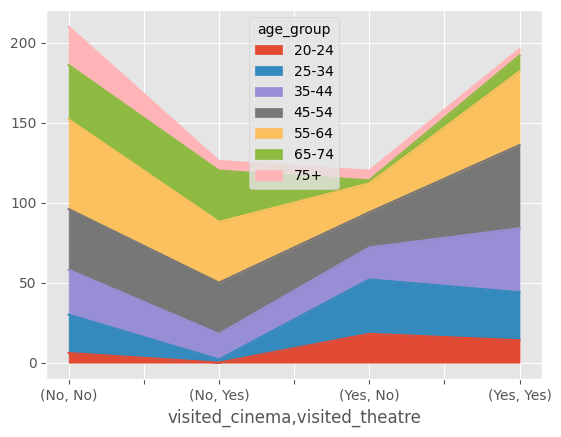

In [567]:
df.groupby('age_group', observed=False)[['visited_cinema', 'visited_theatre']].value_counts().unstack('age_group').plot.area(stacked=True)



- Older people visit less culture events, especially less cinema but prefer only theartre or both but not only cinema.
- 35 - 74 years old's go more theatre than other 75+ and 20-24 yrs olds.
- Overall trend is that people either go to both or neither. 
- Much less people go to only one of the activities

<Axes: xlabel='visited_cinema,visited_theatre'>

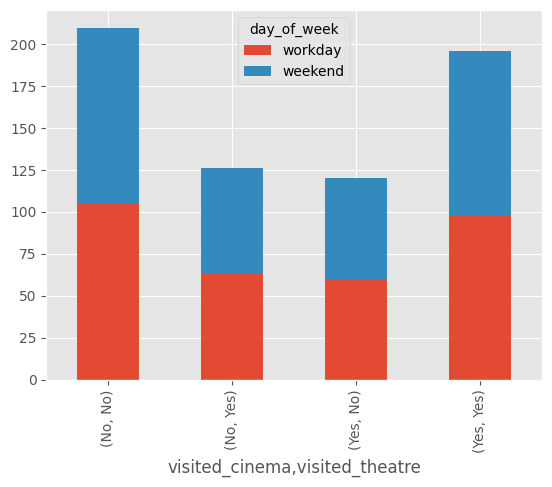

In [568]:
df.groupby('day_of_week', observed=False)[['visited_cinema', 'visited_theatre']].value_counts().unstack('day_of_week').plot.bar(stacked=True)

- ~20% dont go to cinema but goes to theatre 
- ~19% go to cinema but doesn't go to theatre
- ~33,5% does not go to either
- ~31% goes to both cinema and theatre
- There is no or low difference whether it is workday or weekend on the whole population

In [569]:
# Chekcing rows where no time spent on any activity
time_columns = ['t_working', 't_cooking', 't_childcare', 't_activity_w_child']
time_df = df[time_columns]
ids = df.loc[time_df[time_columns].sum(axis=1) == 0].household_id.value_counts()
print("Sum of id's with 0 minutes in all 4 fields:", len(ids))

ids = ids[ids > 1].index
print("Sum of id's where both weekend and workday activities 0 minutes:", len(ids))
ids

df_no_activity = df[(df['household_id'].isin(ids)) & (df['visited_cinema'] == 'No') & (df['visited_theatre'] == 'No') ]

print("Sum of id's that do none of the acts in any day:", int(len(df_no_activity) / 2)) # Amount of individuals that do none of the activities any day

Sum of id's with 0 minutes in all 4 fields: 111
Sum of id's where both weekend and workday activities 0 minutes: 53
Sum of id's that do none of the acts in any day: 18


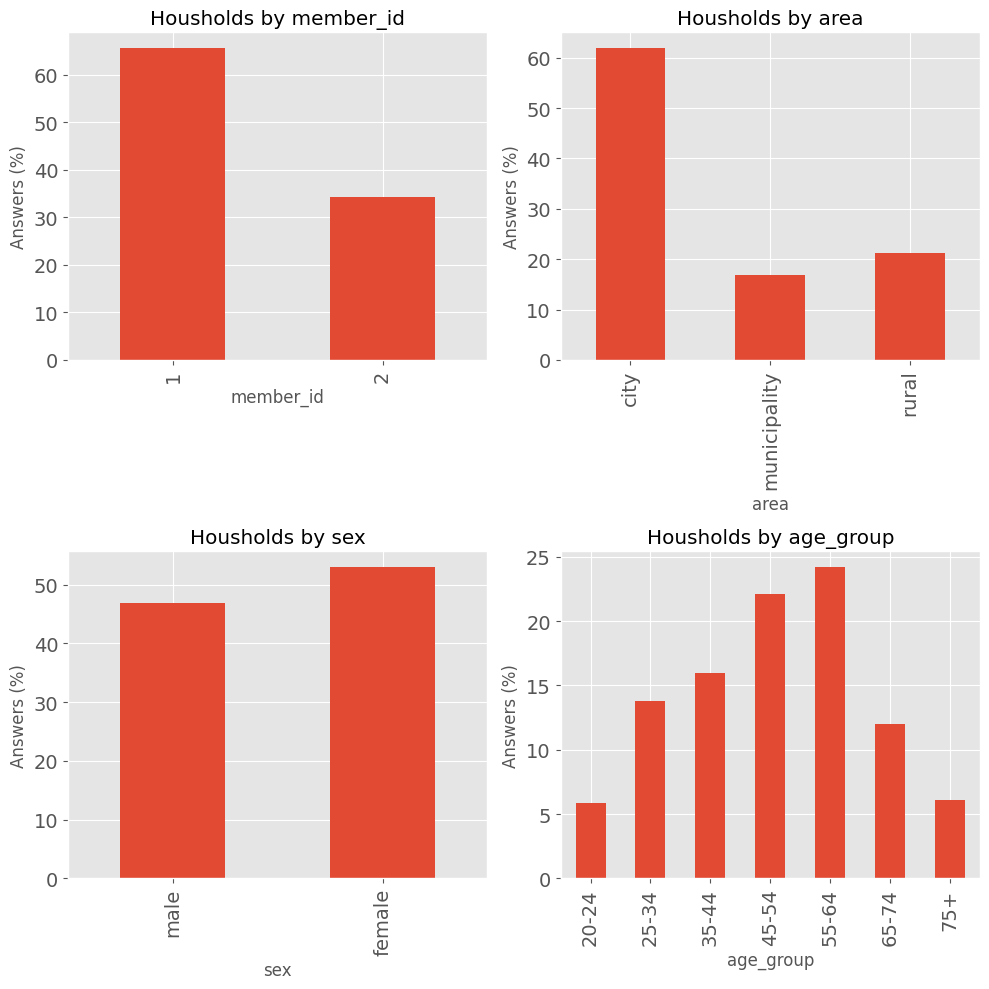

In [570]:
# Trying to create subplots with a loop
#  Age distributions in relation to sex, area are interesting 
demographics = ['member_id', 'area', 'sex', 'age_group']

columns = len(demographics)
rows = int(columns / 2)
fig, axes = plt.subplots(nrows=rows, ncols=2, figsize=(10, 5 * rows))
axes = axes.flatten()

# Previous method axes.flatten() creates a list to iterate over with a single digit
# Subplots for each column with demogrpaphic types
for i, column in enumerate(demographics):
    counts = df.groupby([column], observed=False)['household_id'].nunique()
    percent = (counts / counts.sum()) * 100
    percent.plot.bar(ax=axes[i], fontsize=14)
    axes[i].set_title(f'Housholds by {column}')
    axes[i].set_ylabel('Answers (%)')
    axes[i].set_xlabel(column)

plt.tight_layout()
plt.show()

# Density plots ???

# df[df['sex'] == 'female'].groupby(['age_group', 'area']).size().unstack().plot(xlabel='female', kind='bar', ax=axes[1], stacked=True)


<Axes: ylabel='Density'>

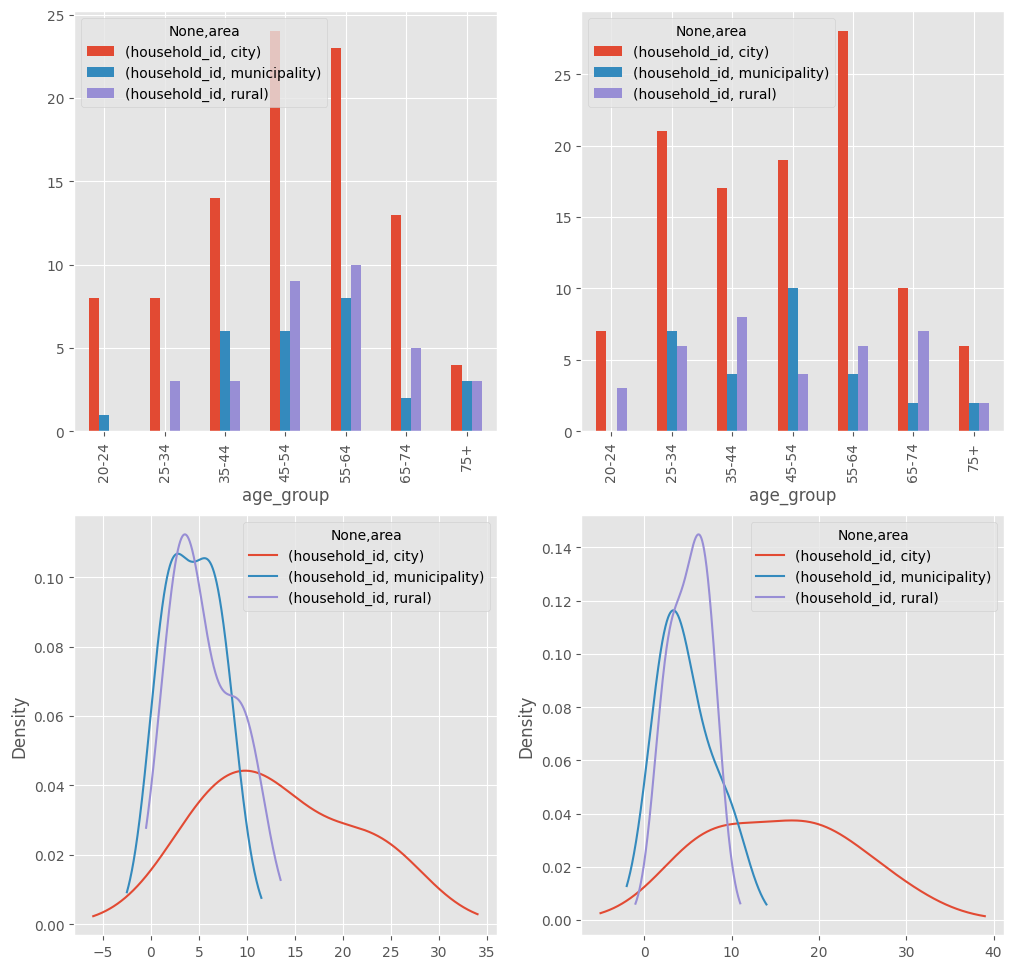

In [571]:
# Creating subplots individually
# Calculated in respect to individual households ~336

# mean values for men and women living in different areas
df_male = df[df['sex'] == 'male'][['household_id','age_group','area']].groupby(['age_group','area'], observed=True).nunique()
df_female = df[df['sex'] == 'female'][['household_id','age_group','area']].groupby(['age_group', 'area'], observed=True).nunique()

fig, axes = plt.subplots(nrows=2, 
                         ncols=2, 
                         figsize=(12, 12))

df_male.unstack('area').plot(kind='bar', ax=axes[0,0])
df_male.unstack('area').plot(kind='density', ax=axes[1,0])
df_female.unstack('area').plot(kind='bar', ax=axes[0,1])
df_female.unstack('area').plot(kind='density', ax=axes[1,1])




Observed = True shows: 
- that there is no younger age_groups in Male population in areas of municipality and rural
- And female population in municipality also lacks answerers

[Text(0.5, 0, 'Female')]

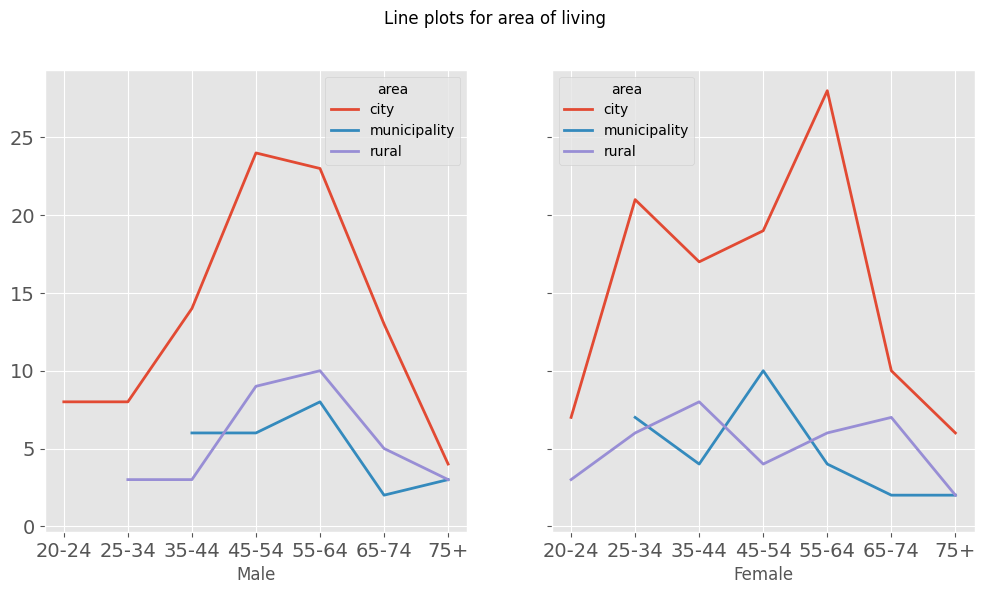

In [572]:
fig, axes = plt.subplots(nrows=1, 
                         ncols=2, 
                         sharey=True, 
                         sharex=True, 
                         figsize=(12, 6),
                         )

# For area duplicates are not needed
unique_df = df.drop_duplicates(subset='household_id', keep='first')
unique_df

unique_df[unique_df['sex'] == 'male'].groupby(['age_group', 'area'], observed=True).size().unstack('area').plot(kind='line', ax=axes[0], fontsize=14, linewidth=2)
unique_df[unique_df['sex'] == 'female'].groupby(['age_group', 'area'], observed=True).size().unstack('area').plot(kind='line', ax=axes[1], fontsize=14, linewidth=2)

fig.suptitle('Line plots for area of living')
axes[0].set(xlabel='Male')
axes[1].set(xlabel='Female')

In [573]:
sex_sums = df[['sex']].value_counts()
ratio = sex_sums.female.sum() / sex_sums.male.sum()
ratio
# There is {ratio} times more female than men overall

1.130718954248366

### 2.2 Numerical variables measuring time
mean median std deviation and frequencies



#### means ans deviations without grouping

In [574]:
list = ['t_working', 't_cooking', 't_childcare', 't_activity_w_child']
# print(df['day_of_week' == 'workday'][list].std())
weekday_mean = df[df['day_of_week'] == 'workday'][list].mean()
workday_mean = df[df['day_of_week'] == 'weekend'][list].mean()

weekday_std = df[df['day_of_week'] == 'workday'][list].std()
workday_std = df[df['day_of_week'] == 'weekend'][list].std()

deviations = pd.concat([weekday_mean, workday_mean, weekday_std, workday_std], axis=1, keys=['workday mean', 'weekend mean', 'workday Std', 'Weekend Std']).round(2)
# deviations.plot(kind='scatter')


#### Grouped by sex

In [575]:
list = ['sex','t_working', 't_cooking', 't_childcare', 't_activity_w_child']
weekday_mean = df[df['day_of_week'] == 'workday'][list].groupby('sex', observed=False).mean()
pd.concat([weekday_mean], axis=1, keys=['workday mean']).round(2)

workday mean                                         
          t_working t_cooking t_childcare t_activity_w_child
sex                                                         
male         111.24     20.46        3.73               0.85
female       113.87     37.23       15.61               5.95

In [576]:
list = ['sex','t_working', 't_cooking', 't_childcare', 't_activity_w_child']
weekend_mean = df[df['day_of_week'] == 'weekend'][list].groupby('sex', observed=False).mean()
pd.concat([weekend_mean], axis=1, keys=['Weekend mean']).round(2)

Weekend mean                                         
          t_working t_cooking t_childcare t_activity_w_child
sex                                                         
male         104.31     17.71        2.88               2.42
female       100.75     39.94       17.46               7.23

#### Grouped by age_group

In [577]:
list = ['age_group','t_working', 't_cooking', 't_childcare', 't_activity_w_child']
weekday_mean = df[df['day_of_week'] == 'workday'][list].groupby('age_group', observed=False).mean()
pd.concat([weekday_mean], axis=1, keys=['workday mean']).round(2)

workday mean                                         
             t_working t_cooking t_childcare t_activity_w_child
age_group                                                      
20-24           123.68     16.84        2.63               2.63
25-34           129.56     19.78       32.00              11.56
35-44           170.00     31.35       27.69               9.23
45-54           178.75     29.58        4.44               1.53
55-64            78.99     33.92        0.25               0.00
65-74            15.13     29.74        0.00               0.00
75+               0.00     38.00        0.00               0.00

In [578]:
weekend_mean = df[df['day_of_week'] == 'weekend'][list].groupby('age_group', observed=False).mean()
pd.concat([weekend_mean], axis=1, keys=['Weekend mean']).round(2)

Weekend mean                                         
             t_working t_cooking t_childcare t_activity_w_child
age_group                                                      
20-24            95.79     10.00        1.05               5.79
25-34            90.67     19.11       43.56              21.56
35-44           178.27     33.27       24.81               9.04
45-54           194.44     25.69        2.64               0.97
55-64            48.48     34.05        0.00               0.00
65-74             8.46     38.72        0.00               0.00
75+               3.00     39.50        0.00               0.00

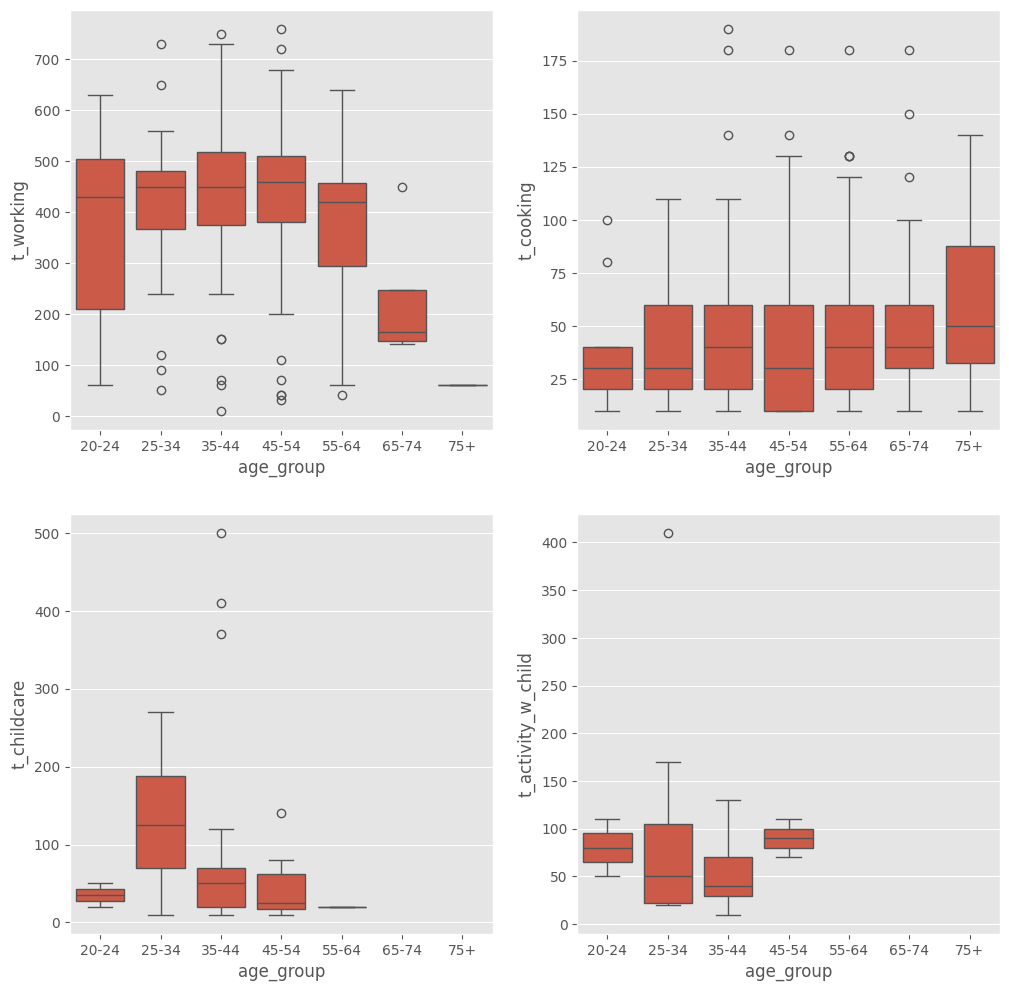

In [579]:
fig, axes = plt.subplots(nrows=2, 
                         ncols=2, 
                         figsize=(12, 12))


sns.boxplot(x='age_group', y='t_working', data=df.replace(0, pd.NA),ax=axes[0,0])
sns.boxplot(x='age_group', y='t_cooking', data=df.replace(0, pd.NA),ax=axes[0,1])
sns.boxplot(x='age_group', y='t_childcare', data=df.replace(0, pd.NA),ax=axes[1,0])
sns.boxplot(x='age_group', y='t_activity_w_child', data=df.replace(0, pd.NA),ax=axes[1,1])
plt.show()

#### Grouped by area

In [580]:
list = ['area','t_working', 't_cooking', 't_childcare', 't_activity_w_child']
weekday_mean = df[df['day_of_week'] == 'workday'][list].groupby('area', observed=False).mean()
pd.concat([weekday_mean], axis=1, keys=['workday mean']).round(2)

workday mean                                         
                t_working t_cooking t_childcare t_activity_w_child
area                                                              
city                99.26     29.90        7.38               3.61
municipality       154.73     32.36       20.91               6.73
rural              118.26     25.36        9.13               0.87

In [581]:
weekend_mean = df[df['day_of_week'] == 'weekend'][list].groupby('area', observed=False).mean()
pd.concat([weekend_mean], axis=1, keys=['Weekend mean']).round(2)

Weekend mean                                         
                t_working t_cooking t_childcare t_activity_w_child
area                                                              
city               102.67     28.71        9.85               3.47
municipality       105.64     29.27       20.00              12.00
rural               99.13     32.03        5.36               3.77

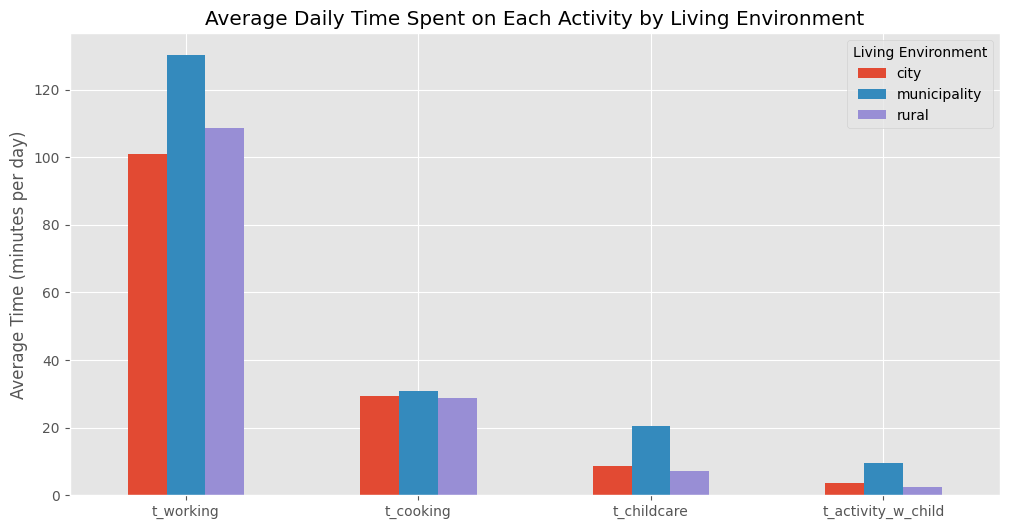

In [582]:
area_means = df[list].groupby('area', observed=False).mean()

area_means.T.plot(kind='bar', figsize=(12, 6))
plt.title("Average Daily Time Spent on Each Activity by Living Environment")
plt.ylabel("Average Time (minutes per day)")
plt.legend(title="Living Environment")
plt.xticks(rotation=0)
plt.show()

- T_working, std deviation indicates high difference in working time values because mean is only less than 2 hours

- Same gous through out the data. It seems time spent on these activities are quite low on average with respectively high deviation, that indicates that most of whom spend time on these activities spend significantly more than the average and many people do not spend time at all or very little

- I there is groups that are employed and unemployed. Groups that have childern or grandchildren or live at home, therefore spending time on childcare and act_w_child. 

- Means and deviations with groups age, sex and municipality should be done to observe more.

### 2.3 Categorical variables characteristics

173


[Text(0, 0, 'city'), Text(1, 0, 'municipality'), Text(2, 0, 'rural')]

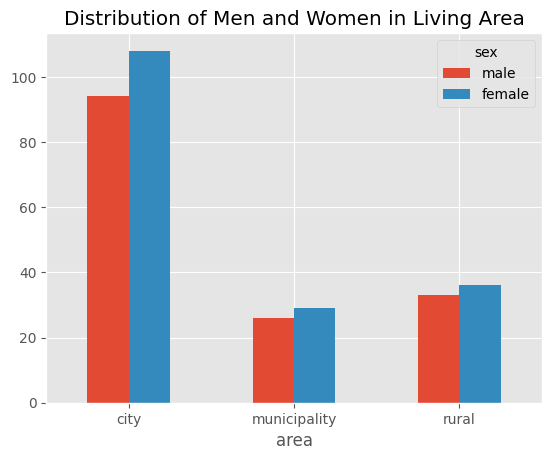

In [583]:
# Living area distribution
counts = df['area'].value_counts().copy()

women_count = (df.drop_duplicates(subset='household_id')['sex'] == 'female').sum()
print(women_count)
area_sex_counts = df.groupby(['area', 'sex'], observed=False).size().unstack().copy()
axis3 = (area_sex_counts / 2).plot(kind='bar', title='Distribution of Men and Women in Living Area')
axis3.set_xticklabels(axis3.get_xticklabels(), rotation=0)



In [584]:
# Filter the dataframe to include only rows where Day_of_Week is 1
df_workday = df[df['day_of_week'] == 2].copy()

# Convert to numeric
df_scatter_workday = df_workday.apply(pd.to_numeric, errors='coerce')

# Select the columns to normalize (columns 5 to 9)
columns_to_normalize = df_scatter_workday.columns[5:10]

# Apply the rank method to normalize to percentiles
df_scatter_workday[columns_to_normalize] = df_scatter_workday[columns_to_normalize].rank(pct=True)

# Ensure 'Visited_Theatre' is of type int64
df_scatter_workday['visited_theatre'] = df_scatter_workday['visited_theatre'].astype('int64')

# Plot the scatter matrix
# scatter_matrix = pd.plotting.scatter_matrix(df_scatter_workday.iloc[:, 4:10], figsize=(10, 10))


In [585]:
# Plot distributions of categorical variables
categorical_columns = ['day_of_week', 'sex', 'age_group', 'area']  # Day of week, Sex, Age, Area

<Axes: xlabel='age_group'>

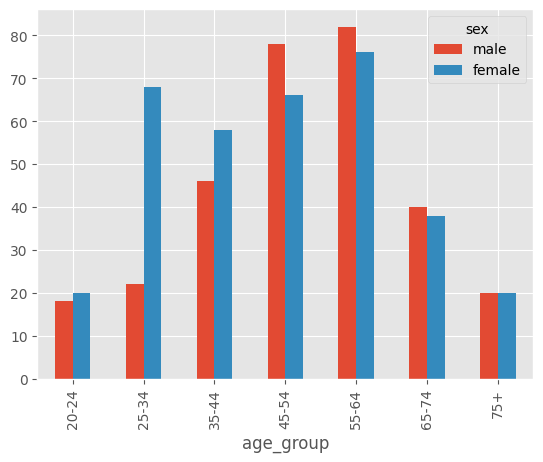

In [586]:
df_sex_age = df.groupby('sex', observed=False)['age_group'].value_counts()
df_sex_age.unstack('sex').plot.bar(stacked=False)

### 2.4 Recognizing groups by activity

#### Answering to questions
3. With respect to which activities do men and women differ?
4. With respect to which activities do living environments differ?

Employed and unemployed
People who go to theatre and cinema tend to live in citys
Cook a lot -> lives somewhere?

Employment percentage in citys and other areas

#### Employed and unemployed dataframes

In [587]:
employed = df[df['t_working'] > 0]
unemployed = df[df['t_working'] == 0]
employed.head()


# working = numerical['t_working']
# cooking = numerical['t_cooking']
# childcare = numerical['t_childcare']
# w_child = numerical['t_activity_w_child']


,household_id,member_id,day_of_week,sex,age_group,area,t_working,t_childcare,t_activity_w_child,t_cooking,visited_cinema,visited_theatre
1,50002,1,weekend,male,45-54,city,380,0,0,10,No,No
4,50004,2,workday,male,55-64,city,640,0,0,0,No,Yes
18,50028,1,weekend,female,35-44,city,440,0,0,0,Yes,No
19,50030,1,workday,male,45-54,municipality,430,0,0,20,Yes,Yes
23,50034,1,workday,female,45-54,city,440,0,0,10,No,Yes


In [588]:
employed['visited_cinema'] = employed['visited_cinema'].map({'Yes': 1, 'No': 0}).astype(bool)
employed['visited_theatre'] = employed['visited_theatre'].map({'Yes': 1, 'No': 0}).astype(bool)
unemployed['visited_cinema'] = unemployed['visited_cinema'].map({'Yes': 1, 'No': 0}).astype(bool)
unemployed['visited_theatre'] = unemployed['visited_theatre'].map({'Yes': 1, 'No': 0}).astype(bool)

C:\Users\Arde\AppData\Local\Temp\ipykernel_10528\1812855333.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  employed['visited_cinema'] = employed['visited_cinema'].map({'Yes': 1, 'No': 0}).astype(bool)
C:\Users\Arde\AppData\Local\Temp\ipykernel_10528\1812855333.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  employed['visited_theatre'] = employed['visited_theatre'].map({'Yes': 1, 'No': 0}).astype(bool)
C:\Users\Arde\AppData\Local\Temp\ipykernel_10528\1812855333.py:3: SettingWithCopyWarning: 
A value

#### 2.4.1 Visited theatre and cinema

##### Visited activities //  group 'age'

In [589]:
employed.groupby('age_group', observed=False)[['visited_theatre', 'visited_cinema']].mean()

,visited_theatre,visited_cinema
age_group,,
20-24,0.181818,0.636364
25-34,0.291667,0.875000
35-44,0.500000,0.523810
45-54,0.645161,0.483871
55-64,0.535714,0.500000
65-74,0.500000,0.500000
75+,1.000000,0.000000


In [590]:
unemployed.groupby('age_group', observed=False)[['visited_theatre', 'visited_cinema']].mean()

,visited_theatre,visited_cinema
age_group,,
20-24,0.444444,0.925926
25-34,0.378788,0.651515
35-44,0.564516,0.612903
45-54,0.536585,0.536585
55-64,0.530769,0.384615
65-74,0.540541,0.135135
75+,0.230769,0.256410


##### Visited activities // group 'sex'

In [591]:
employed.groupby('sex', observed=False)[['visited_theatre', 'visited_cinema']].mean()

,visited_theatre,visited_cinema
sex,,
male,0.386667,0.413333
female,0.608247,0.670103


In [592]:
unemployed.groupby('sex', observed=False)[['visited_theatre', 'visited_cinema']].mean()

,visited_theatre,visited_cinema
sex,,
male,0.463203,0.393939
female,0.510040,0.518072


#### 2.4.2 Time spent on activities 

##### Time spent // group 'sex'

In [593]:
# employed.groupby('age_group').value_counts()['t_working']
# Group by 'age_group' in the employed DataFrame
employed.groupby('sex', observed=False)[['t_working', 't_cooking', 't_childcare', 't_activity_w_child']].mean().round(3)


,t_working,t_cooking,t_childcare,t_activity_w_child
sex,,,,
male,439.733,18.267,4.667,0.933
female,382.784,27.938,12.990,3.299


In [594]:
unemployed.groupby('sex', observed=False)[['t_working', 't_cooking', 't_childcare', 't_activity_w_child']].mean().round(3)


,t_working,t_cooking,t_childcare,t_activity_w_child
sex,,,,
male,0.0,19.351,2.857,1.861
female,0.0,42.731,17.912,7.871


##### Time spent // group 'age'

In [595]:
employed.groupby('age_group', observed=False)[['t_working', 't_cooking', 't_childcare', 't_activity_w_child']].mean().round(3)

,t_working,t_cooking,t_childcare,t_activity_w_child
age_group,,,,
20-24,379.091,21.818,0.000,0.000
25-34,412.917,19.583,32.083,8.333
35-44,431.190,27.857,11.190,2.857
45-54,433.387,23.387,5.645,1.129
55-64,359.643,22.857,0.714,0.000
65-74,230.000,27.500,0.000,0.000
75+,60.000,0.000,0.000,0.000


In [596]:
unemployed.groupby('age_group', observed=False)[['t_working', 't_cooking', 't_childcare', 't_activity_w_child']].mean().round(3)

,t_working,t_cooking,t_childcare,t_activity_w_child
age_group,,,,
20-24,0.0,10.000,2.593,5.926
25-34,0.0,19.394,39.848,19.545
35-44,0.0,35.323,36.452,13.387
45-54,0.0,30.854,1.951,1.341
55-64,0.0,36.385,0.000,0.000
65-74,0.0,34.595,0.000,0.000
75+,0.0,39.744,0.000,0.000


##### Time spent // group 'area'

In [597]:
employed.groupby('area', observed=False)[['t_working', 't_cooking', 't_childcare', 't_activity_w_child']].mean().round(3)

,t_working,t_cooking,t_childcare,t_activity_w_child
area,,,,
city,407.900,25.000,9.100,3.000
municipality,397.778,23.056,18.611,0.556
rural,416.667,20.833,0.833,1.944


#### 2.4.3 People who are working all week

In [598]:
df_w = df[df['t_working'] > 0]
id_counts = df_w.groupby('household_id', observed=False).size()
id_two_entries = id_counts[id_counts == 2].index

df_w[df_w['household_id'].isin(id_two_entries)].copy()

,household_id,member_id,day_of_week,sex,age_group,area,t_working,t_childcare,t_activity_w_child,t_cooking,visited_cinema,visited_theatre
64,50151,1,workday,male,20-24,city,630,0,0,100,Yes,No
65,50151,1,weekend,male,20-24,city,530,0,0,20,Yes,No
76,50203,1,workday,male,35-44,rural,580,0,0,0,No,No
77,50203,1,weekend,male,35-44,rural,520,0,0,0,No,No
147,50378,1,workday,female,45-54,city,540,0,0,20,Yes,No
148,50378,1,weekend,female,45-54,city,590,10,0,70,Yes,No
186,50518,1,workday,male,45-54,rural,490,0,0,50,No,Yes
187,50518,1,weekend,male,45-54,rural,70,0,70,20,No,Yes
208,50584,2,workday,female,35-44,city,530,0,0,50,No,Yes
209,50584,2,weekend,female,35-44,city,60,0,0,40,No,Yes


In [599]:
df_wc = df[df['t_working'] > 0]
df_wc[df_wc['t_cooking'] > 0]

,household_id,member_id,day_of_week,sex,age_group,area,t_working,t_childcare,t_activity_w_child,t_cooking,visited_cinema,visited_theatre
1,50002,1,weekend,male,45-54,city,380,0,0,10,No,No
19,50030,1,workday,male,45-54,municipality,430,0,0,20,Yes,Yes
23,50034,1,workday,female,45-54,city,440,0,0,10,No,Yes
26,50050,1,weekend,female,55-64,city,420,0,0,30,Yes,Yes
40,50098,1,weekend,female,45-54,city,400,40,0,70,Yes,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...
708,51904,1,weekend,female,25-34,city,50,270,110,40,Yes,No
711,51914,2,workday,female,45-54,city,40,0,0,30,Yes,Yes
712,51914,2,weekend,female,45-54,city,620,0,0,10,Yes,Yes
733,51967,1,workday,male,55-64,rural,420,0,0,80,No,No


In [600]:
df_wc = df[df['t_working'] == 0]
df_wc[df_wc['t_cooking'] > 0]

,household_id,member_id,day_of_week,sex,age_group,area,t_working,t_childcare,t_activity_w_child,t_cooking,visited_cinema,visited_theatre
2,50003,1,workday,female,35-44,municipality,0,50,0,60,No,Yes
3,50003,1,weekend,female,35-44,municipality,0,50,0,50,No,Yes
5,50004,2,weekend,male,55-64,city,0,0,0,10,No,Yes
6,50005,1,workday,female,45-54,city,0,0,0,80,No,No
7,50005,1,weekend,female,45-54,city,0,0,0,40,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...
732,51960,2,weekend,male,55-64,city,0,0,0,20,Yes,Yes
734,51967,1,weekend,male,55-64,rural,0,0,0,70,No,No
738,51973,1,weekend,male,35-44,municipality,0,0,0,10,Yes,No
743,51983,1,workday,female,65-74,rural,0,0,0,40,Yes,No


In [601]:
# Calculate median for each activity, excluding zero values
household_medians_nonzero = df[df['t_working'] > 0].groupby('household_id')['t_working'].median().median(), \
                            df[df['t_cooking'] > 0].groupby('household_id')['t_cooking'].median().median(), \
                            df[df['t_childcare'] > 0].groupby('household_id')['t_childcare'].median().median(), \
                            df[df['t_activity_w_child'] > 0].groupby('household_id')['t_activity_w_child'].median().median()

print("Median time spent (excluding zero values):\n", household_medians_nonzero)


Median time spent (excluding zero values):
 (445.0, 37.5, 50.0, 52.5)


#### By workday and weekend

In [602]:
df_weekday = df[df['day_of_week'] == 'workday']
df_weekend = df[df['day_of_week'] == 'weekend']

#### People who are not working

In [603]:
df_wc = df_weekday[df_weekday['t_working'] == 0]
df_wc_ck = df_wc[df_wc['t_cooking'] == 0]
df_wc.describe().round(2)

,household_id,t_working,t_childcare,t_activity_w_child,t_cooking
count,237.00,237.0,237.00,237.00,237.00
mean,50998.10,0.0,10.76,4.77,30.84
std,604.61,0.0,46.93,20.47,37.79
min,50002.00,0.0,0.00,0.00,0.00
25%,50394.00,0.0,0.00,0.00,0.00
50%,51027.00,0.0,0.00,0.00,20.00
75%,51498.00,0.0,0.00,0.00,50.00
max,51983.00,0.0,410.00,170.00,190.00


## 3. Patterns and hypothesis

1. Characterise the individuals that are present in the data. Are there groups of similar persons?
    Trivial groups -> Age, Area, sex
    Groups via activity -> how to know??

    Not so trivial groups -> employed, unemployed, cook alot?, with children, visitin culture, not visiting culture

2. Estimate how much time on average households spend daily on each activity.
    Mean values + medians, -> Task: calculate medians

5. Which activities are associated with each other?
    Task: calculate Correlations with activities

## An analysis based on visual representation of the data

### Basic Characteristics of the Population
The population sample reveals an urban-centric distribution, with over 60% living in cities, about 20% in rural areas, and less than 20% in municipalities. Age-wise, the distribution skews slightly left, with nearly half (46%) aged 45-64. There is a notable drop in the population over age 65, comprising only around 18% of the sample. Regarding gender, the split is relatively even, with men at 47% and women at 53%. However, a significant skew is observed in the 25-34 age group, where the male population is over three times larger than the female population, likely impacting characteristics and activity patterns within this age bracket.

### Participation in Cultural Activities: Theatre and Cinema
Patterns of participation in cultural activities such as theatre and cinema show distinct trends. Around 20% of respondents attend only the theatre, while 19% attend only the cinema. The majority of the population prefers either both or neither of these activities, with 34% attending neither and 31% participating in both. Notably, there is minimal variation in cultural attendance between weekdays and weekends, suggesting a stable participation rate regardless of the day. When broken down by age, younger individuals (under 35) are more likely to attend the cinema, while older individuals (over 55) favor the theatre. Overall, these findings indicate a preference for engaging in both activities or neither rather than selecting one over the other.

### Living Environment Distribution by Age and Gender
Urban residency is the most common across all age groups and for both men and women, with no significant differences between genders. In contrast, those living in municipalities and rural areas are more evenly distributed across age brackets, lacking a clear age or gender skew. These findings highlight the homogeneity of urban living among the sample and suggest that rural and municipal areas attract a more age-diverse population.

### Activity Patterns by Sex
A closer look at activity distributions reveals that both men and women allocate similar amounts of time to work, suggesting balanced employment engagement across genders. However, notable differences emerge in other daily activities. Women, for instance, spend about 1.8 times more time on cooking during weekdays than men, and this difference increases on weekends, with women spending 2.3 times more than men. A similar gender disparity is seen in childcare activities, where women devote five times more time to childcare than men on average, highlighting gendered differences in household responsibilities.

### Activity Patterns by Age
Age significantly impacts daily activity engagement, particularly in work and childcare. Those aged 35-54 report the highest average time spent working, with the widest distribution found among the 20-24 age group, suggesting that this age group includes both full-time students and full-time workers. Cooking time remains relatively consistent across all age groups, though younger individuals (under 35) generally spend less time cooking than their older counterparts. Childcare engagement peaks among individuals aged 25-34, likely reflecting a higher prevalence of young children in this age group. Older individuals (over 65) spend minimal or no time on childcare.

### Activity Patterns by Living Environment
Differences also appear when analyzing activity patterns by living environment. Individuals in municipalities, for example, report more time spent on all measured activities compared to their urban and rural counterparts. This difference is most pronounced in childcare, suggesting that families with younger children may gravitate towards municipalities, possibly due to a balance between urban amenities and a quieter living environment suitable for raising children.

### Activity Patterns by Employment Status
Employment status significantly influences activity engagement, particularly regarding work, cultural participation, and household responsibilities. Those who report zero minutes working are likely unemployed or retired. Employed women show a higher likelihood of participating in cultural activities, with 60% attending the theatre and 67% visiting the cinema, compared to 51% and 52%, respectively, among unemployed women. Interestingly, no such difference is observed among male participants. Furthermore, unemployed women spend an average of 15 additional minutes daily on cooking compared to their employed counterparts, suggesting that employment status impacts household responsibilities. Employed men work almost an hour more per day than employed women on average, which may reflect occupational gender differences. Unemployed individuals, particularly those aged 35-44, spend more time on childcare, possibly indicating maternity or parental leave.

### Conclusion
The population data reveal distinct patterns that intersect across demographic and socioeconomic variables, providing insights into how different groups engage in daily activities. Urban residency is predominant, with a generally even gender split, though notable variations appear in the 25-34 age group. Cultural engagement patterns show a preference for attending both or neither of the theatre and cinema, with age-based preferences favoring cinema for younger individuals and theatre for older individuals. Gendered differences are evident in household responsibilities, with women more engaged in cooking and childcare across age and employment statuses. Additionally, municipal living correlates with higher engagement in all activities, especially childcare, while unemployed individuals tend to spend more time on caregiving, suggesting possible familial or parental roles. This analysis offers a comprehensive view of the population's engagement across daily activities, elucidating how age, gender, employment, and living environment collectively shape individual and group behavior.


## 4. Statistical Analysis

1. Kruskal-Wallis test for numerical variables t_activities

2. Pearsons Chi-squared test for multiple categorical values -> value_counts as occurrences

1. Difference in groups
    1. Unemployed - employed
    1. Working only 
2. Find out if activities attract certain people
3. 

### 4.1. Kruskal Wallis test  

H0 is that the given groups do not different from each other

H1 is one or more of the groups have differences in distribution

In [607]:
# Groups and activities to test
act_list = ['t_working', 't_cooking', 't_childcare', 't_activity_w_child']
unemployed_act_list = ['t_cooking', 't_childcare', 't_activity_w_child']
groups = ['age_group', 'sex', 'area']
results = {}

for activity in act_list:
    for group in groups:
        print(f"Running Kruskal-Wallis test for activity '{activity}' grouped by '{group}':")
        
        # # # #
        # Choose whole population or exclude observations with 0 minutes
        
        # group_data = [df[df[group] == g][activity].values for g in df[group].unique()] # Whole population
        # group_data = [df[df[group] == g][activity].replace(0, pd.NA).dropna().values for g in df[group].unique()] # Excluding obs with 0 minutes
        group_data = [employed[employed[group] == g][activity].values for g in df[group].unique()] # Employed

        # Unemployed
        # if activity == 't_working':
        #     continue
        # group_data = [unemployed[unemployed[group] == g][activity].values for g in df[group].unique()] # Unemployed
         
        stat, p_value = S.kruskal(*group_data)
        print(f"H-statistic: {stat}, p-value: {p_value}")
        
        if p_value < 0.05:
            print("Significant differences found.")
            results[(activity, group)] = {
                'kruskal_p': p_value,
                'significant': True,
            }
        else:
            print("No significant differences found among groups.")
            results[(activity, group)] = {
                'kruskal_p': p_value,
                'significant': False,
            }
        print("\n")  # For readability

print(pd.DataFrame.from_dict(results).T) 


Running Kruskal-Wallis test for activity 't_working' grouped by 'age_group':
H-statistic: 11.530333900156657, p-value: 0.07330503673571383
No significant differences found among groups.


Running Kruskal-Wallis test for activity 't_working' grouped by 'sex':
H-statistic: 6.347879179646686, p-value: 0.011752171128233329
Significant differences found.


Running Kruskal-Wallis test for activity 't_working' grouped by 'area':
H-statistic: 0.6060864797098484, p-value: 0.7385671601431723
No significant differences found among groups.


Running Kruskal-Wallis test for activity 't_cooking' grouped by 'age_group':
H-statistic: 5.0673431444522326, p-value: 0.5352053657029916
No significant differences found among groups.


Running Kruskal-Wallis test for activity 't_cooking' grouped by 'sex':
H-statistic: 7.959458212331264, p-value: 0.004783673129216875
Significant differences found.


Running Kruskal-Wallis test for activity 't_cooking' grouped by 'area':
H-statistic: 1.3868868796902787, p-valu

### Chi-squared test to analyse cultural activity

## Conclusions on statistical testing

Since the time measuring variables' values had respectively inconsistent distributions and frequency. We dicided to use Kruskal-Wallis method to test differences in time spent on different activities between categorical groups such as age, sex and area of living.

### Kruskal Wallis method for the whole population:

Statistically significant differences were found in time spent on working, based on an age group. This complements our findigs from exploratory analysis where high averages were reported with those aged 35-54 with relative low variation, while among the 20-24 age group had the widest distribution indicating a lot of both full time workers and unemployed people. 

Significant differences were observed in the time spent cooking based on both sex and age group. These findings align with our exploratory analysis, which indicated that sex was a key factor, with individuals spending 1.8 to 2.3 times more minutes cooking depending on the day of the week. While the visual differences based on age group were less pronounced in the exploratory analysis, a minor difference was noted, with younger and older participants appearing to diverge around the age of 35.

Significant differences were consistently observed in both t_childcare and t_activity_w_child across all demographic factors analyzed. These findings are consistent with our exploratory analysis, which indicated that women spend more time  in activities with and caring for children. Additionally, we noted a tendency for individuals aged 25 to 34 to dedicate more time to child-related activities, as well as notable difference based on municipal areas that might attract families.

Statistically, no notable differences were observed in the time spent working across age groups and areas, nor in the time spent cooking within different areas. Though time spent accross all activities, was sligthly higher in municipal areas. 

### Kruskal Wallis method for only those enganing in given activities:

The most meaningful results were derived from the analysis of time spent working and cooking, with time spent working produced more insights into the data, while time spent cooking reflected the same patterns within overall population. In contrast, the data regarding childcare and activity had fewer observations and included some NaN values from Kruskall test, which were therefore not considered in the analysis. However, these can be reproduced using the provided code.

Statistically, there is a significant difference in time spent working between genders. This may be due to a couple of factors: first, the population has 13% more female participants than male participants, and second, male participants, on average, worked 60 minutes more per day than their female counterparts.

### Kruskal Wallis method for employed and unemployed people:

For emploeyed participants there were few key results.
Among employed people differences in time working were distinguishable only between genders compared to the whole population were differences were significant accross age groups, but no other groups. 

The analysis indicates that unemployed individuals have significant variations in their engagement accross all activities. Particularly age and sex. In contrast, employed individuals show fewer significant differences overall, with notable findings primarily related to sex in the context of cooking and childcare. Employment status may influence the time allocation and activities performed, particularly in relation to gender and age. 

In [ ]:
act_list = ['t_working', 't_cooking', 't_childcare', 't_activity_w_child']
groups = ['age_group', 'sex', 'area']
group_data = [df[df[group] == g][activity].values for g in df[group]]
group_data

In [ ]:
df_weekday_time = df_weekday[['t_working', 't_cooking', 't_childcare', 't_activity_w_child']]
df_weekend_time = df_weekend[['t_working', 't_cooking', 't_childcare', 't_activity_w_child']]
df_weekday_time.describe().round(2)

### 4.2. Activities
3. With respect to which activities do men and women differ?
4. With respect to which activities do living environments differ?
5. Which activities are associated with each other?

### Correlation matrix of activities

In [ ]:
# Replace 'Yes' with 1 and 'No' with 0
df['visited_cinema'] = df['visited_cinema'].map({'Yes': 1, 'No': 0})
df['visited_theatre'] = df['visited_theatre'].map({'Yes': 1, 'No': 0})

df_activities = df[['t_working', 't_cooking', 't_childcare', 't_activity_w_child', 'visited_cinema', 'visited_theatre']]
correlations = df_activities.corr(method='spearman')

# Plot heatmap of correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlations, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix of Activities")
plt.show()

### Statistical test time spent by groups

#### Mann-Whitney U-Test for Working time grouped by sex

In [ ]:
# Mann whitney U Test since not normal unpaired variables
# N0: The distributions of the two groups are the same
# N1: The distributions of the two groups are different

employed_m = employed[employed['sex'] == 'male']
employed_f = employed[employed['sex'] == 'female']

s1 = pd.Series(employed_m['t_working'])
s2 = pd.Series(employed_f['t_working']) 

result_e_w = S.mannwhitneyu(s1,s2, use_continuity=True, alternative='two-sided')[1]
result_e_w
print("Result P < 0.05:", f'{result_e_w < 0.05}, P =', result_e_w.round(4))
# print(S.kruskal(s1, s2).pvalue, end="\n\n")



In [ ]:
# Mann whitney U Test since not normal unpaired variables
# N0: The distributions of the two groups are the same
# N1: The distributions of the two groups are different

employed_m = employed[employed['sex'] == 'male']
employed_f = employed[employed['sex'] == 'female']

s1 = pd.Series(employed_m['t_cooking'])
s2 = pd.Series(employed_f['t_cooking']) 

result_e_c = S.mannwhitneyu(s1,s2, use_continuity=True, alternative='two-sided')[1]
result_e_c
print("Result P < 0.05:", f'{result_e_c < 0.05}, P =',result_e_c.round(4))

In [ ]:
# Mann whitney U Test since not normal unpaired variables
# N0: The distributions of the two groups are the same
# N1: The distributions of the two groups are different

employed_m = employed[employed['sex'] == 'male']
employed_f = employed[employed['sex'] == 'female']

s1 = pd.Series(employed_m['t_childcare'])
s2 = pd.Series(employed_f['t_childcare']) 

result_e_cc = S.mannwhitneyu(s1,s2, use_continuity=True, alternative='two-sided')[1]
result_e_cc
print("Result P < 0.05:", f'{result_e_cc < 0.05}, P =',result_e_cc.round(4))

In [ ]:
# Mann whitney U Test since not normal unpaired variables
# N0: The distributions of the two groups are the same
# N1: The distributions of the two groups are different

employed_m = employed[employed['sex'] == 'male']
employed_f = employed[employed['sex'] == 'female']

s1 = pd.Series(employed_m['t_activity_w_child'])
s2 = pd.Series(employed_f['t_activity_w_child']) 

result_e_twc = S.mannwhitneyu(s1,s2, use_continuity=True, alternative='two-sided')[1]
result_e_twc
print("Result P < 0.05:", f'{result_e_twc < 0.05}, P =',result_e_twc.round(4))

In [ ]:
# all mann whitney U tests for employed grouped by sex
pd.DataFrame({'t_working': result_e_w, 't_cooking': result_e_c, 't_childcare': result_e_cc, 't_activity_w_child': result_e_twc}, index=['Mann Whitney U Test, male and female'])

- For the mann whitney u tests. Statistically there is significant difference in t_cooking, t_working and t_childcare. 
- With respect to the  means measured earlier, men seem to work more hours, spend less time cooking and with child. 
- In t_activity_w_child there is statistically no significant difference.
